In [1]:
# If needed (run once)
# !pip install -q pyspark==3.5.1 datasets pandas pyarrow scikit-learn matplotlib

import os, time, json, shutil
from datetime import datetime, timezone

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    StructType, StructField, LongType, StringType, DoubleType
)

from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, FeatureHasher, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import (
    LogisticRegression, RandomForestClassifier, LinearSVC, DecisionTreeClassifier
)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
RUN_TAG = datetime.now(timezone.utc).strftime("%Y%m%d_%H%M%S")

# Choose where you want artifacts saved (edit if you like)
PROJECT_ROOT = os.path.abspath("./cifer_full_run")
RAW_DIR = os.path.join(PROJECT_ROOT, "raw_cache")
PARQUET_DIR = os.path.join(PROJECT_ROOT, "parquet")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
REPORTS_DIR = os.path.join(PROJECT_ROOT, "reports")

for p in [RAW_DIR, PARQUET_DIR, MODELS_DIR, REPORTS_DIR]:
    os.makedirs(p, exist_ok=True)

TRACE_LOG = os.path.join(REPORTS_DIR, f"trace_{RUN_TAG}.jsonl")
SCORECARD_CSV = os.path.join(REPORTS_DIR, f"scorecard_{RUN_TAG}.csv")

DATASET_ID = "CiferAI/Cifer-Fraud-Detection-Dataset-AF"
HF_SPLIT = "train"

# ====== IMPORTANT knobs (adjust to your machine) ======
# These fractions ONLY affect tuning/evaluation runtime.
# Full data is still loaded and stored as Parquet.
CV_TRAIN_FRACTION = 0.02   # 2% stratified sample for CrossValidator training
TEST_FRACTION     = 0.02   # 2% stratified sample for evaluation
# =====================================================

def trace(event: str, payload: dict):
    row = dict(payload)
    row["event"] = event
    row["run_tag"] = RUN_TAG
    row["ts_utc"] = datetime.now(timezone.utc).isoformat()
    with open(TRACE_LOG, "a", encoding="utf-8") as f:
        f.write(json.dumps(row) + "\n")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RUN_TAG:", RUN_TAG)

PROJECT_ROOT: /home/acer1/sparkenv/cifer_full_run
RUN_TAG: 20260226_070742


In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Cifer_LocalSafe")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.ui.host", "127.0.0.1")
    .config("spark.ui.port", "4041")

    # more driver heap
    .config("spark.driver.memory", "6g")

    # small local settings
    .config("spark.sql.shuffle.partitions", "8")
    .config("spark.default.parallelism", "8")

    # reduce broadcast + memory pressure
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")
print("Spark:", spark.version)
print("UI: http://localhost:4041")

your 131072x1 screen size is bogus. expect trouble
26/02/26 07:07:44 WARN Utils: Your hostname, LAPTOP-JGP66BV5 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/02/26 07:07:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/26 07:07:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark: 3.5.1
UI: http://localhost:4041


In [4]:
# Output paths
FULL_PARQUET_PATH = os.path.join(PARQUET_DIR, "cifer_full_train_parquet")
FULL_CSV_PATH = os.path.join(PARQUET_DIR, "cifer_full_train.csv")

if not os.path.exists(FULL_PARQUET_PATH):

    print("[HF] Loading full dataset from Hugging Face (this can take a while)...")

    t0 = time.time()
    ds = load_dataset(DATASET_ID, split=HF_SPLIT)
    print("[HF] Loaded rows:", len(ds), "secs:", round(time.time() - t0, 2))

    # -------------------------
    # Save PARQUET (FAST for Spark)
    # -------------------------
    print("[HF] Writing Parquet dataset...")
    t1 = time.time()
    ds.to_parquet(FULL_PARQUET_PATH)
    print("[HF] Parquet written:", FULL_PARQUET_PATH,
          "secs:", round(time.time() - t1, 2))

    # -------------------------
    # Save CSV (for inspection / backup)
    # -------------------------
    print("[HF] Writing CSV file...")

    t2 = time.time()

    # Convert to pandas only if memory allows
    df_pd = ds.to_pandas()

    df_pd.to_csv(FULL_CSV_PATH, index=False)

    print("[HF] CSV written:", FULL_CSV_PATH,
          "secs:", round(time.time() - t2, 2))

    trace("hf_full_saved", {
        "parquet_path": FULL_PARQUET_PATH,
        "csv_path": FULL_CSV_PATH,
        "rows": len(ds)
    })

else:
    print("[HF] Parquet already exists:", FULL_PARQUET_PATH)
    trace("hf_full_parquet_exists", {"path": FULL_PARQUET_PATH})

[HF] Parquet already exists: /home/acer1/sparkenv/cifer_full_run/parquet/cifer_full_train_parquet


In [5]:
df0 = spark.read.parquet(FULL_PARQUET_PATH)
trace("spark_parquet_read", {"cols": len(df0.columns)})

# Basic type casting & cleaning (safe defaults)
df0 = df0.withColumn("type", F.coalesce(F.col("type").cast("string"), F.lit("UNKNOWN")))

# Drop isFlaggedFraud as requested
if "isFlaggedFraud" in df0.columns:
    df0 = df0.drop("isFlaggedFraud")

# Clamp negative numeric values
for c in ["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]:
    df0 = df0.withColumn(c, F.when(F.col(c) < 0, 0.0).otherwise(F.col(c)))

# Create label column and drop original
df = df0.withColumn("label", F.col("isFraud").cast("int")).drop("isFraud")

# Validate label domain
df = df.filter(F.col("label").isin(0, 1))
N_PER_CLASS = 500

fraud_df = df.filter(F.col("label") == 1)
nonfraud_df = df.filter(F.col("label") == 0)

# Random sample (stable seed)
fraud_sample = fraud_df.orderBy(F.rand(42)).limit(N_PER_CLASS)
nonfraud_sample = nonfraud_df.orderBy(F.rand(99)).limit(N_PER_CLASS)

# Combine
df = fraud_sample.unionByName(nonfraud_sample).orderBy(F.rand(7)).cache()

print("[Balanced sample rows]:", df.count())

print("[Class distribution]:")
df.groupBy("label").count().show()

trace("balanced_sample_created", {"rows": df.count(), "per_class": N_PER_CLASS})

print("[Spark] Columns:", df.columns)
print("[Spark] Example:")
df.select("step","type","amount","label").show(5, truncate=False)

# This is a big dataset: avoid df.count() unless you want to wait
trace("spark_cleaned_ready", {"note": "cleaned dataframe ready"})

[Balanced sample rows]: 1000
[Class distribution]:
+-----+-----+
|label|count|
+-----+-----+
|    1|  500|
|    0|  500|
+-----+-----+

[Spark] Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'label']
[Spark] Example:
+----+--------+---------+-----+
|step|type    |amount   |label|
+----+--------+---------+-----+
|508 |CASH_OUT|276457.98|0    |
|155 |CASH_IN |409559.4 |1    |
|743 |CASH_IN |344058.41|0    |
|190 |PAYMENT |16565.89 |0    |
|370 |PAYMENT |76653.73 |1    |
+----+--------+---------+-----+
only showing top 5 rows



In [6]:
from pyspark.sql import functions as F

df.coalesce(1).write.mode("overwrite").option("header", True).csv(
    os.path.join(PROJECT_ROOT, "balanced_500_per_class")
)
df.groupBy("label").count().show()
train_df, test_df = df.randomSplit([0.8, 0.2], seed=7)
train_df = train_df.cache()
test_df = test_df.cache()
_ = train_df.count(); _ = test_df.count()

+-----+-----+
|label|count|
+-----+-----+
|    1|  500|
|    0|  500|
+-----+-----+



In [7]:
type_index = StringIndexer(inputCol="type", outputCol="type_idx", handleInvalid="keep")
type_ohe = OneHotEncoder(inputCols=["type_idx"], outputCols=["type_vec"], handleInvalid="keep")

# Hash high-cardinality IDs
id_hash = FeatureHasher(inputCols=["nameOrig", "nameDest"], outputCol="id_vec", numFeatures=2**16)

num_cols = ["step","amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"]
assemble = VectorAssembler(inputCols=num_cols + ["type_vec","id_vec"],
                           outputCol="features", handleInvalid="keep")
scale = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                       withStd=True, withMean=False)

prep_stages = [type_index, type_ohe, id_hash, assemble, scale]

In [8]:
auc_eval = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
prec_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
rec_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

candidates = {
    "lr":  LogisticRegression(featuresCol="scaledFeatures", labelCol="label", maxIter=30),
    "svm": LinearSVC(featuresCol="scaledFeatures", labelCol="label", maxIter=30),
    "dt":  DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="label", maxDepth=6),
    "rf":  RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=120, maxDepth=10),
}

# Keep grids small to avoid exploding runtime
grids = {
    "lr": (ParamGridBuilder()
           .addGrid(candidates["lr"].regParam, [0.0, 0.01])
           .addGrid(candidates["lr"].elasticNetParam, [0.0, 0.5])
           .build()),
    "svm": (ParamGridBuilder()
            .addGrid(candidates["svm"].regParam, [0.01, 0.1])
            .build()),
    "dt": (ParamGridBuilder()
           .addGrid(candidates["dt"].maxDepth, [4, 6, 8])
           .build()),
    "rf": (ParamGridBuilder()
           .addGrid(candidates["rf"].maxDepth, [6, 10])
           .addGrid(candidates["rf"].numTrees, [80, 120])
           .build()),
}

results = []
conf_mats = {}  # store TP/FP/FN/TN per model

for name, est in candidates.items():
    print(f"\n[TRAIN] {name}")

    pipe = Pipeline(stages=prep_stages + [est])

    cv = CrossValidator(
        estimator=pipe,
        estimatorParamMaps=grids[name],
        evaluator=auc_eval,
        numFolds=2,          # change to 3 if required (slower)
        parallelism=2,
        collectSubModels=False
    )

    t0 = time.time()
    fitted = cv.fit(train_df)
    fit_s = time.time() - t0

    best = fitted.bestModel
    pred = best.transform(test_df).select("label","prediction","rawPrediction")

    auc = float(auc_eval.evaluate(pred))
    acc = float(acc_eval.evaluate(pred))
    f1  = float(f1_eval.evaluate(pred))
    pw  = float(prec_eval.evaluate(pred))
    rw  = float(rec_eval.evaluate(pred))

    cm = pred.select(
        F.sum(F.when((F.col("label")==1) & (F.col("prediction")==1), 1).otherwise(0)).alias("TP"),
        F.sum(F.when((F.col("label")==0) & (F.col("prediction")==1), 1).otherwise(0)).alias("FP"),
        F.sum(F.when((F.col("label")==1) & (F.col("prediction")==0), 1).otherwise(0)).alias("FN"),
        F.sum(F.when((F.col("label")==0) & (F.col("prediction")==0), 1).otherwise(0)).alias("TN"),
    ).collect()[0]

    TP, FP, FN, TN = int(cm["TP"]), int(cm["FP"]), int(cm["FN"]), int(cm["TN"])
    conf_mats[name] = (TP, FP, FN, TN)

    # Save best model
    model_path = os.path.join(MODELS_DIR, f"{name}_best_{RUN_TAG}")
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
    best.write().overwrite().save(model_path)

    row = {
        "run_tag": RUN_TAG,
        "model": name,
        "fit_seconds": float(fit_s),
        "auc": auc,
        "accuracy": acc,
        "f1": f1,
        "precision_weighted": pw,
        "recall_weighted": rw,
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "model_path": model_path
    }
    results.append(row)
    trace("model_finished", row)

    print(f"[METRICS] AUC={auc:.4f} ACC={acc:.4f} F1={f1:.4f} TP={TP} FP={FP} FN={FN} TN={TN}")
    print("[SAVED]", model_path)

scorecard = pd.DataFrame(results).sort_values("auc", ascending=False)
scorecard.to_csv(SCORECARD_CSV, index=False)
trace("scorecard_saved", {"scorecard_csv": SCORECARD_CSV, "n_models": len(results)})

print("\nScorecard:", SCORECARD_CSV)
scorecard


[TRAIN] lr


26/02/26 07:08:08 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:08:08 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:08:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:08:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:08:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:08:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:08:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:08:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:08:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
26/02/26 07:08:12 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
26/02/26 07:08:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 

[METRICS] AUC=0.4870 ACC=0.4925 F1=0.4535 TP=74 FP=79 FN=22 TN=24
[SAVED] /home/acer1/sparkenv/cifer_full_run/models/lr_best_20260226_070742

[TRAIN] svm


26/02/26 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:10:01 WARN DAGScheduler: Broadcasting larg

[METRICS] AUC=0.5070 ACC=0.4925 F1=0.4895 TP=55 FP=60 FN=41 TN=43
[SAVED] /home/acer1/sparkenv/cifer_full_run/models/svm_best_20260226_070742

[TRAIN] dt


26/02/26 07:12:04 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
26/02/26 07:12:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
26/02/26 07:12:07 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
26/02/26 07:12:08 WARN DAGScheduler: Broadcasting larg

[METRICS] AUC=0.4579 ACC=0.5678 F1=0.5071 TP=20 FP=10 FN=76 TN=93
[SAVED] /home/acer1/sparkenv/cifer_full_run/models/dt_best_20260226_070742

[TRAIN] rf


26/02/26 07:12:35 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:35 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/26 07:12:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
26/02/26 07:12:37 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
26/02/26 07:12:37 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
26/02/26 07:12:38 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
26/02/26 07:12:38 WARN DAGScheduler: Broadcasting larg

[METRICS] AUC=0.4894 ACC=0.4774 F1=0.3512 TP=90 FP=98 FN=6 TN=5
[SAVED] /home/acer1/sparkenv/cifer_full_run/models/rf_best_20260226_070742

Scorecard: /home/acer1/sparkenv/cifer_full_run/reports/scorecard_20260226_070742.csv


,run_tag,model,fit_seconds,auc,accuracy,f1,precision_weighted,recall_weighted,TP,FP,FN,TN,model_path
1,20260226_070742,svm,122.461025,0.506978,0.492462,0.489530,0.495675,0.492462,55,60,41,43,/home/acer1/sparkenv/cifer_full_run/models/svm...
3,20260226_070742,rf,40.057261,0.489432,0.477387,0.351157,0.466209,0.477387,90,98,6,5,/home/acer1/sparkenv/cifer_full_run/models/rf_...
0,20260226_070742,lr,110.197867,0.486954,0.492462,0.453475,0.503369,0.492462,74,79,22,24,/home/acer1/sparkenv/cifer_full_run/models/lr_...
2,20260226_070742,dt,28.427044,0.457929,0.567839,0.507085,0.606435,0.567839,20,10,76,93,/home/acer1/sparkenv/cifer_full_run/models/dt_...


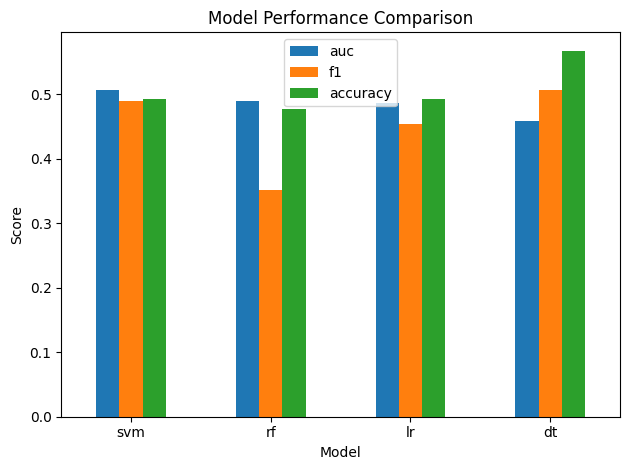

In [9]:
metrics_to_plot = ["auc", "f1", "accuracy"]
plot_df = scorecard[["model"] + metrics_to_plot].set_index("model")

ax = plot_df.plot(kind="bar")
ax.set_title("Model Performance Comparison")
ax.set_ylabel("Score")
ax.set_xlabel("Model")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

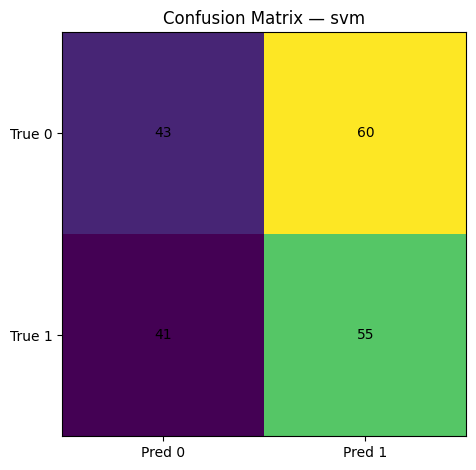

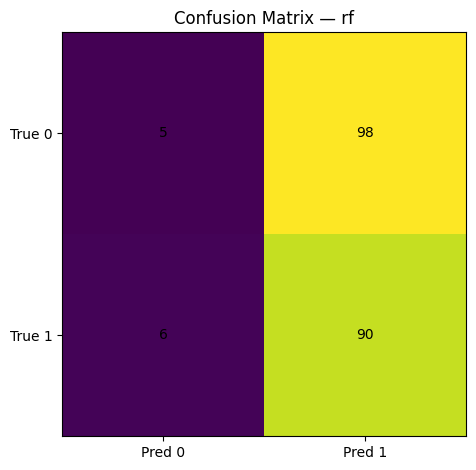

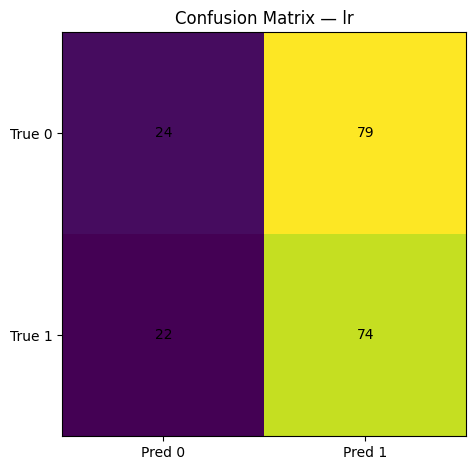

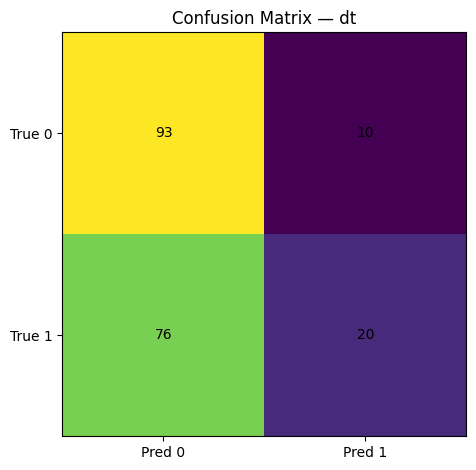

In [10]:
def plot_confusion(TP, FP, FN, TN, title):
    mat = np.array([[TN, FP],
                    [FN, TP]], dtype=int)

    fig, ax = plt.subplots()
    im = ax.imshow(mat)  # default colormap
    ax.set_title(title)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    for (i, j), v in np.ndenumerate(mat):
        ax.text(j, i, str(v), ha="center", va="center")

    plt.tight_layout()
    plt.show()

for m in scorecard["model"]:
    TP, FP, FN, TN = conf_mats[m]
    plot_confusion(TP, FP, FN, TN, f"Confusion Matrix — {m}")

In [13]:
train_df.unpersist()
test_df.unpersist()
print("Done.")

Done.
